# Differential gene expression

Differential gene expression (DGE) analysis identifies genes that show statistically significant differences in expression levels across distinct cell populations or conditions.
This analysis helps in identifying which cell types are most affected by a condition of interest such as a disease, and characterizing their functional signatures. 

Pertpy provides an API to access several types of models for differential expression analysis.
The first group of models comprises the T-test and Wilcoxon test as simple statistical tests for comparing expression values between two groups without covariates.
The second group includes models of the linear model family that allow modeling complex designs and contrasts. Currently included are [PyDESeq2](https://academic.oup.com/bioinformatics/article/39/9/btad547/7260507), [edgeR](https://academic.oup.com/bioinformatics/article/26/1/139/182458) as well as a wrapper around statsmodels [Statsmodels](https://www.statsmodels.org). which provides access to a wide range of regression models, including ordinary least squares regression, robust linear models and generalized linear models.

In the following tutorial we will demonstrate how the edgeR interface can be used to model complex interactions using the triple-negative breast cancer (TNBC) [Zhang dataset](https://www.sciencedirect.com/science/article/pii/S1535610821004992).

## Environment setup

Note that the differential gene expression interface requires the `de` extra of pertpy to be installed (`pip install pertpy[de]`).

In [1]:
import warnings

import decoupler as dc
import pertpy as pt
import scanpy as sc

warnings.filterwarnings("ignore")

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

The Zhang dataset comprises scRNA-seq from 22 patients with advanced TNBC, treated with paclitaxel alone or in combination with the anti-PD-L1 therapy atezolizumab.
78 tumor biopsies and blood samples were collected before treatment ('pre-treatment'), after treatment ('post-treatment), and during disease progression ('progression').
We focused on the transcriptomic data which encompasses approximately 489,490 high-quality immune cells with 27085 measured genes across 99 high resolution cell types.

In [2]:
adata = pt.dt.zhang_2021()

To keep runtimes reasonable and simplify the interpretation, we will only be working with the tissue samples.

In [5]:
adata = adata[adata.obs["Origin"] == "t", :].copy()

In [6]:
adata.obs.head(5)

,Sample,Patient,Origin,Tissue,Efficacy,Group,Treatment,Number of counts,Number of genes,Major celltype,Cluster
Cell barcode,,,,,,,,,,,
AAACCTGAGAGTCTGG.Pre_P007_t,Pre_P007_t,P007,t,lymph_node,PR,Pre-treatment,Anti-PD-L1+Chemo,"2,346",748,T cell,t_Tn-LEF1
AAACCTGAGCACACAG.Pre_P007_t,Pre_P007_t,P007,t,lymph_node,PR,Pre-treatment,Anti-PD-L1+Chemo,"1,242",679,ILC cell,t_ILC1-IL32
AAACCTGCAAGTCATC.Pre_P007_t,Pre_P007_t,P007,t,lymph_node,PR,Pre-treatment,Anti-PD-L1+Chemo,"1,593",597,T cell,t_Tn-LEF1
AAACCTGGTTGGGACA.Pre_P007_t,Pre_P007_t,P007,t,lymph_node,PR,Pre-treatment,Anti-PD-L1+Chemo,"2,404","1,203",T cell,t_CD8_Tem-GZMK
AAACCTGTCAGCTCGG.Pre_P007_t,Pre_P007_t,P007,t,lymph_node,PR,Pre-treatment,Anti-PD-L1+Chemo,"2,034",682,T cell,t_Tn-LEF1


When conducting differential gene expression analysis, it is important to understand the dataset well.
We will therefore explore the various co-variates first.

In [7]:
adata.obs["Patient"].value_counts()

Patient
P019    37150
P013    22526
P012    14570
P025    14505
P002    10909
P022    10614
P023    10123
P005     8175
P018     7936
P020     7240
P007     7237
P003     4349
P016     4009
P017     4006
P004     3887
P010        8
Name: count, dtype: int64

We remove Patient 10 who has had very few sequenced cells.

In [8]:
adata = adata[~adata.obs["Patient"].isin(["P010"])]

In [9]:
adata.obs["Sample"].value_counts()

Sample
Pre_P019_t     27656
Prog_P013_t    10153
Post_P013_t     9975
Post_P019_t     9494
Post_P025_t     8072
Pre_P022_t      7689
Pre_P012_t      7682
Post_P012_t     6888
Pre_P020_t      6863
Post_P023_t     6813
Pre_P025_t      6433
Post_P018_t     5847
Pre_P002_t      5483
Post_P002_t     5426
Pre_P007_t      4999
Pre_P005_t      4432
Post_P003_t     4349
Pre_P004_t      3887
Pre_P016_t      3862
Post_P005_t     3743
Pre_P023_t      3310
Post_P022_t     2925
Pre_P017_t      2428
Pre_P013_t      2398
Prog_P007_t     2238
Pre_P018_t      2089
Post_P017_t     1578
Post_P020_t      377
Post_P016_t      147
Name: count, dtype: int64

Notably, two samples have less than 1000 sequenced cells.
We will not remove them but keep it in mind.

Generally cells can behave quite differently from tissue to tissue.
Therefore, it can be useful to conduct DGE tests per tissue and not all tissues jointly.
To keep things simple, we will not conduct the tests per tissue separately here.

In [10]:
adata.obs["Tissue"].value_counts()

Tissue
lymph_node    60725
breast        50418
liver         30701
chest_wall    23154
brain          2238
Name: count, dtype: int64

Each patient was treated with a different type of therapy and classified based on efficacy of the treatment as responders (PR: partial response) or non-responders (SD: stable disease, PD: progressive disease).

In [60]:
adata.obs["Treatment"].value_counts()

Treatment
Anti-PD-L1+Chemo    85797
Chemo               77293
Name: count, dtype: int64

In [61]:
adata.obs["Efficacy"].value_counts()

Efficacy
PR    99337
SD    59404
PD     4349
Name: count, dtype: int64

Samples were collected both before and after treatment

In [12]:
adata.obs["Group"].value_counts()

Group
Pre-treatment     89211
Post-treatment    65634
Progression       12391
Name: count, dtype: int64

The dataset was annotated with two levels of cell type annotation:

In [13]:
adata.obs["Major celltype"].value_counts()

Major celltype
T cell          100155
B cell           35588
Myeloid cell     19878
ILC cell         11615
Name: count, dtype: int64

In [14]:
adata.obs["Cluster"].value_counts()

Cluster
t_Tn-LEF1           19046
t_CD8_Tem-GZMK      15371
t_Bmem-CD27         12639
t_CD4_Tcm-LMNA      10886
t_CD8-CXCL13        10689
t_Bn-TCL1A           9695
t_pB-IGHG1           8505
t_CD4_Tact-XIST      8497
t_CD4_Treg-FOXP3     7893
t_CD8_Trm-ZNF683     6456
t_CD4-CXCL13         6282
t_CD8_MAIT-KLRB1     4791
Mix                  4146
t_CD8_Teff-GNLY      3517
t_Bfoc-MKI67         2717
t_Tact-IFI6          2487
t_macro-IL1B         2148
t_macro-IL1RN        1973
t_Bfoc-NEIL1         1865
t_ILC3-AREG          1772
t_mono-FCN1          1684
t_ILC1-VCAM1         1613
t_macro-IGFBP7       1493
t_macro-MGP          1338
t_ILC1-FGFBP2        1309
t_ILC1-SELL          1297
t_ILC1-CD160         1097
t_macro-IFI27        1051
t_macro-TUBA1B       1050
t_ILC1-IL32           972
t_macro-CX3CR1        947
t_ILC2-SPON2          942
t_cDC2-CLEC10A        926
t_macro-MKI67         873
t_ILC1-IFNG           751
t_macro-SPP1          742
t_macro-CCL2          733
t_macro-MMP9          664
t_IL

We remove the `Mix` cell type analogously to the original publication.

In [15]:
adata = adata[~adata.obs["Cluster"].isin(["Mix"])]

For the remainder of the analysis we will work with the `Cluster` level because the `Major celltype` level is not fine-grained enough.

We store the raw counts in a counts layer because most DGE models expect raw counts.

In [16]:
adata.layers["counts"] = adata.X.copy()

## Pseudobulks

To perform DE analysis on our single-cell dataset, we first create pseudobulk samples by aggregating expression counts of cells within each group and sample of interest. This approach allows us to leverage statistical methods originally developed for bulk RNA-seq data, which is the recommended [best practice](https://www.sc-best-practices.org/conditions/differential_gene_expression.html) to minimizing false positives in scRNA-seq DE analysis. 
<!-- Both DESeq2 and edgeR are differential gene expression testing tools implemented in R which were initially designed for bulk gene expression data. Both implement a wide range of statistical methodologies based on the negative binomial distribution, empirical Bayes estimation, exact tests, generalized linear models (GLMs) and quasi-likelihood tests. -->

For each patient we create 1 pseudobulk sample per cell type by summing up the gene counts within each subpopulation.

In [17]:
ps = pt.tl.PseudobulkSpace()
pdata = ps.compute(
    adata, target_col="Patient", groups_col="Cluster", layer_key="counts", mode="sum", min_cells=10, min_counts=1000
)

In [18]:
pdata

AnnData object with n_obs × n_vars = 457 × 24391
    obs: 'Patient', 'Cluster', 'Origin', 'Efficacy', 'Treatment', 'Major celltype', 'psbulk_n_cells', 'psbulk_counts'
    layers: 'psbulk_props'

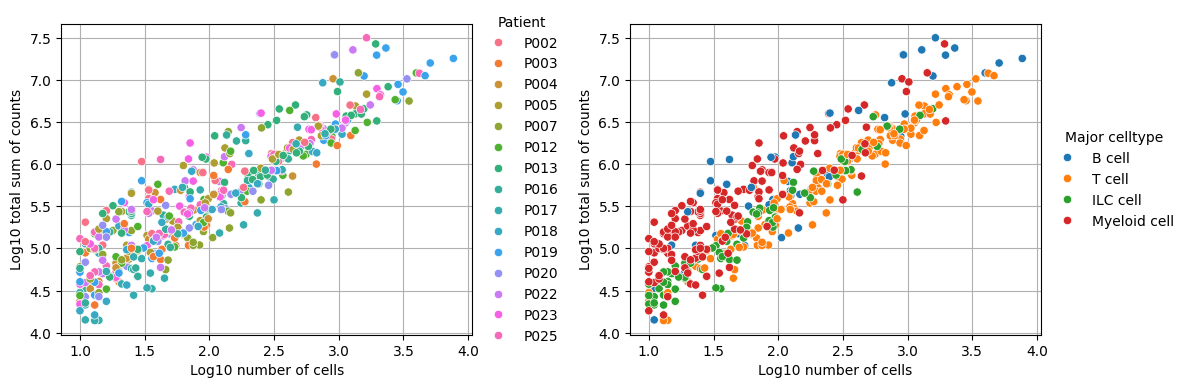

In [19]:
ps.plot_psbulk_samples(pdata, groupby=["Patient", "Major celltype"], figsize=(12, 4))

## Axes of variation

The validity of differential gene expression results highly depends on the capture of the major axis of variations in the statistical model.
Intermediate data exploration steps such as principal component analysis (PCA) or multidimensional scaling (MDS) on pseudobulk samples allow for the identification of the sources of variation and thus can guide the construction of corresponding design and contrast matrices that model the data.

Now that we have generated the pseudobulk profiles for each patient and each cell type, let’s explore the variability between them. For that, we will first do some simple preprocessing and calculate a PCA.

In [20]:
pdata.layers["counts"] = pdata.X.copy()

sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

# Return raw counts to X
dc.swap_layer(pdata, "counts", X_layer_key=None, inplace=True)

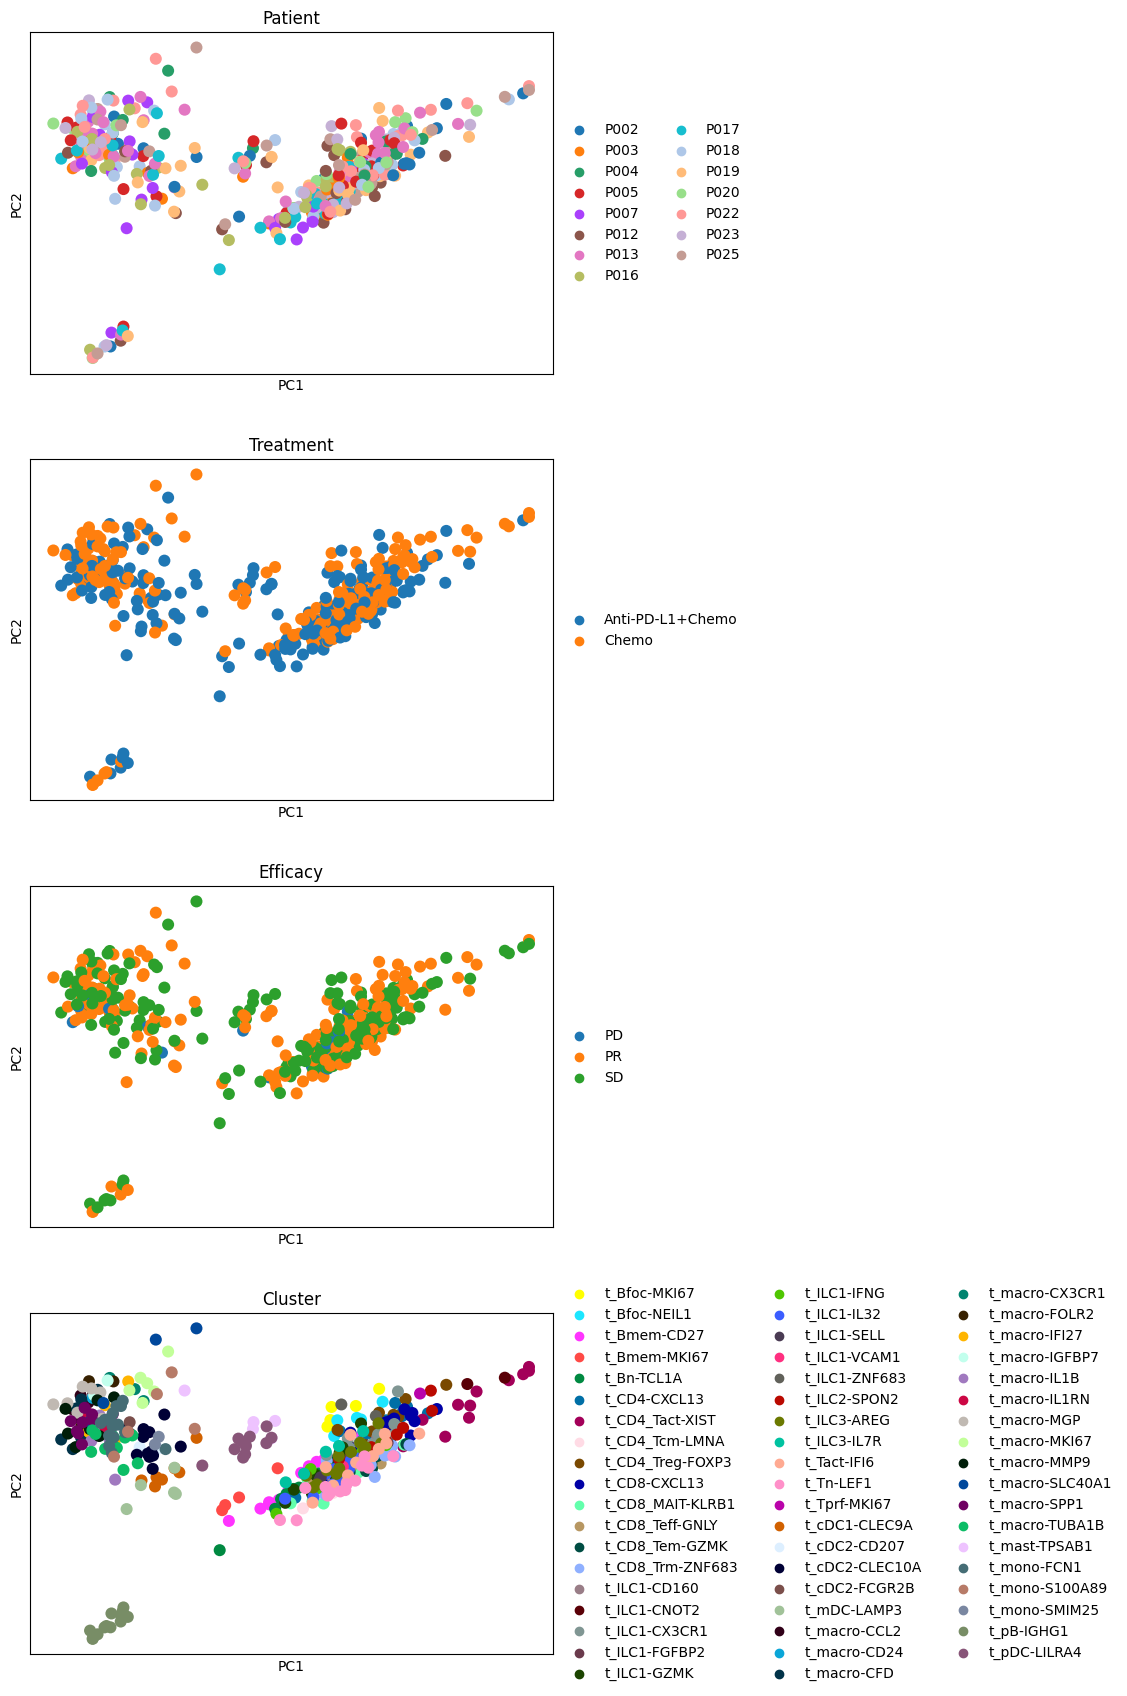

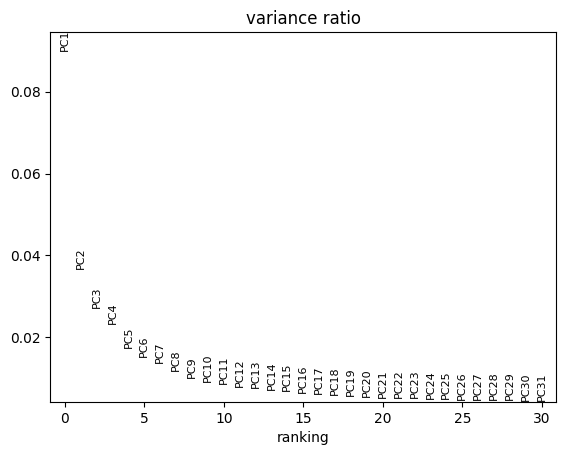

In [21]:
sc.pl.pca(pdata, color=["Patient", "Treatment", "Efficacy", "Cluster"], ncols=1, size=300)
sc.pl.pca_variance_ratio(pdata)

It seems like the four first components explain most of the variance and they easily separate most cell types from one another.
In contrast, the principle components do not seem to be associated with Patient, Efficacy or Treatment.

To have a better overview of the association of PCs with sample metadata, let’s perform ANOVA on each PC and see whether they are significantly associated with any technical or biological annotations of our samples

In [22]:
dc.get_metadata_associations(
    pdata,
    obs_keys=["Patient", "Treatment", "Efficacy", "Cluster", "psbulk_n_cells", "psbulk_counts"],
    obsm_key="X_pca",
    uns_key="pca_anova",
    inplace=True,
)

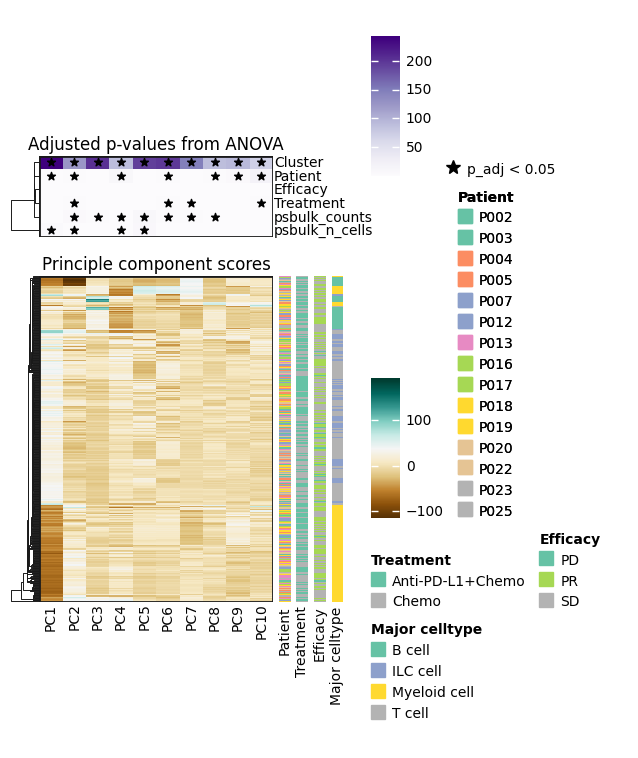

In [25]:
dc.plot_associations(
    pdata,
    uns_key="pca_anova",
    obsm_key="X_pca",
    stat_col="p_adj",
    obs_annotation_cols=["Patient", "Treatment", "Efficacy", "Major celltype"],
    titles=["Principle component scores", "Adjusted p-values from ANOVA"],
)

## Differential expression testing with edgeR

The edger interface further requires edger to be installed in R (`BiocManager::install("edgeR")`).

<!-- The interface for edgeR supports complex designs. -->
Here, we are fit a model to capture that the type of treatment (`Treatment`) and response to the treatment (`Efficacy`) contribute independently to the gene expression levels.
By doing so, we can evaluate:

1. How much of the variation in gene expression can be attributed to differences in drug efficacy, independent of the type of treatment.
2. How much of the variation is due to the type of treatment, independent of the efficacy of the drug.

This setup helps in understanding not just whether a treatment works, but how its effectiveness might vary or be influenced by the inherent efficacy of the drug.

In [26]:
edgr = pt.tl.EdgeR(pdata, design="~Efficacy+Treatment")

In [27]:
edgr.fit()

• Calculating NormFactors
• Estimating Dispersions
• Fitting linear model


To now determine the differentially expressed genes between the treatments, we can specify a contrast as follows:

In [28]:
res_df = edgr.test_contrasts(edgr.contrast(column="Treatment", baseline="Chemo", group_to_compare="Anti-PD-L1+Chemo"))

In [29]:
res_df.head(10)

,variable,log_fc,logCPM,F,p_value,adj_p_value,contrast
0,IGHV1-69,-2.437195,5.603879,628.619045,1.147944e-95,2.799951e-91,None
1,HBB,1.163613,9.259467,365.636265,3.458685e-61,4.218040e-57,None
2,RPS26,1.365807,10.339090,357.466160,1.096989e-59,8.918884e-56,None
3,FDCSP,4.721393,5.455406,278.073612,1.910520e-52,1.164987e-48,None
4,AZGP1,-2.875646,3.409497,167.358718,2.013021e-34,9.819921e-31,None
5,AC135068.2,-3.971118,3.342327,159.027709,1.723130e-32,7.004809e-29,None
6,CCL19,3.820760,4.235494,139.355345,2.409439e-29,8.395518e-26,None
7,IGLV5-48,-4.359268,5.474016,139.473320,3.975637e-29,1.212122e-25,None
8,HTN1,6.541613,3.908961,162.621356,9.757945e-29,2.644512e-25,None
9,IGHV3-64,-4.138466,4.904814,135.394006,2.061377e-28,5.027905e-25,None


The set of differentially expressed genes can now be used for downstream tasks or as a first step, plotted in a volcano plot.

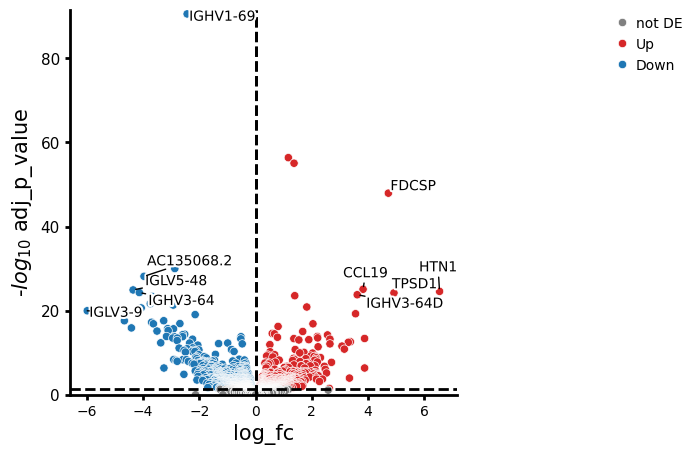

In [30]:
edgr.plot_volcano(res_df, log2fc_thresh=0)

We identified genes that are differentially expressed between the two treatments. Next, we might be interested in looking at the expression levels of these genes across different subgroups. Those subgroups could be different patients or, as in this case, different efficacy groups. For this, we can use the `plot_paired` function, which enables comparing expression levels between paired samples. Note that the pairing must have been considered in the model design.

• Performing pseudobulk for paired samples
! 1 unpaired samples removed


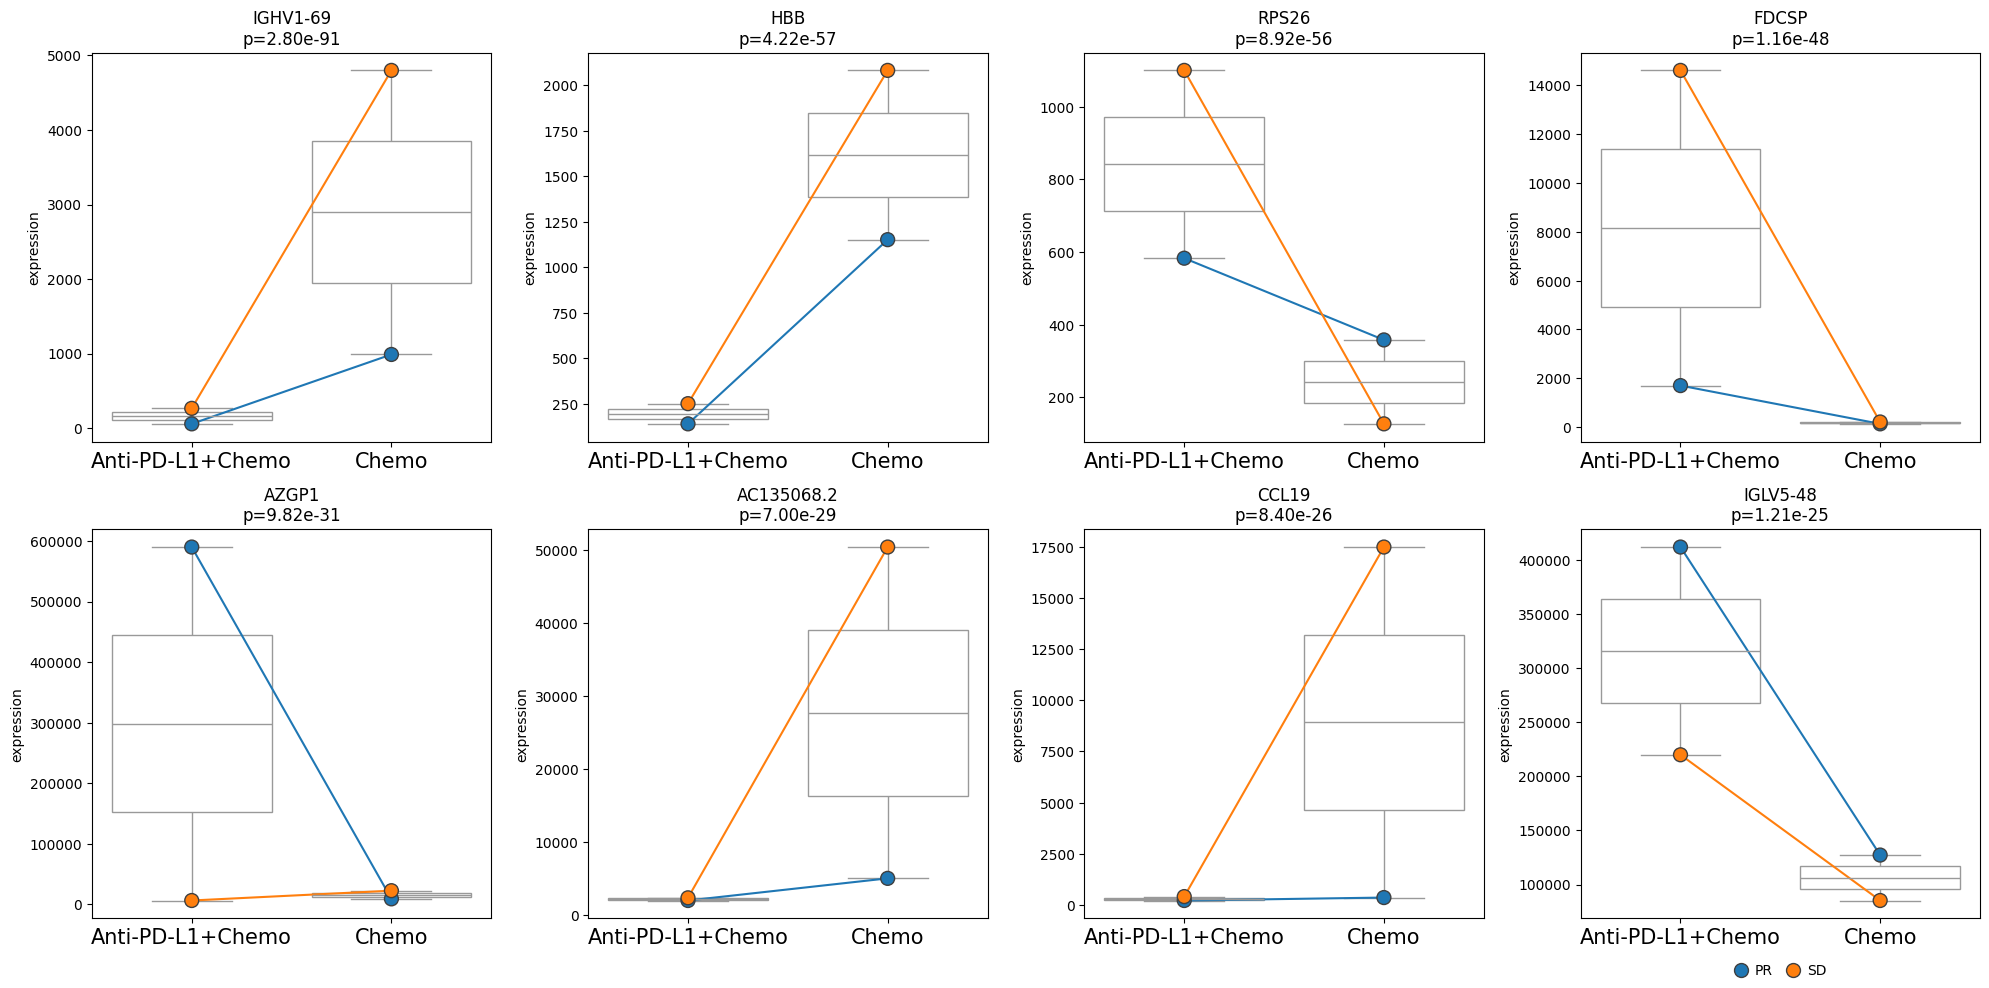

In [31]:
edgr.plot_paired(pdata, results_df=res_df, n_top_vars=8, groupby="Treatment", pairedby="Efficacy")

Furthermore, we can also compare the gene expression levels between the different efficacy groups. For this, we use the `compare_groups` function.
Specifically, we will use the "Stable Disease" (SD) group as the baseline and compare it to the "Partial Response" (PR) and "Progressive Disease" (PD) groups.

• Calculating NormFactors
• Estimating Dispersions
• Fitting linear model


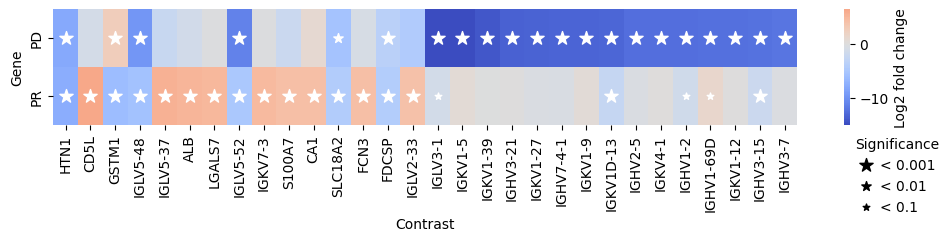

In [32]:
res_df = edgr.compare_groups(pdata, column="Efficacy", baseline="SD", groups_to_compare=["PR", "PD"])
edgr.plot_multicomparison_fc(res_df, figsize=(12, 1.5))

## Differential expression testing with PyDESeq2

The interface of PyDESeq2 in pertpy is very similar.

In [104]:
pds2 = pt.tl.PyDESeq2(adata=pdata, design="~Efficacy+Treatment")

In [105]:
pds2.fit()

Fitting size factors...
... done in 0.20 seconds.

Fitting dispersions...
... done in 1.36 seconds.

Fitting dispersion trend curve...
... done in 0.36 seconds.

Fitting MAP dispersions...
... done in 1.39 seconds.

Fitting LFCs...
... done in 1.84 seconds.

Calculating cook's distance...
... done in 0.53 seconds.

Replacing 729 outlier genes.

Fitting dispersions...
... done in 0.19 seconds.

Fitting MAP dispersions...
... done in 0.18 seconds.

Fitting LFCs...
... done in 0.22 seconds.



In [106]:
res_df = pds2.test_contrasts(pds2.contrast(column="Treatment", baseline="Chemo", group_to_compare="Anti-PD-L1+Chemo"))

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0. -1.]
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG      15.875276       -0.026642  0.091895 -0.289913  0.771883  0.877953
A1BG-AS1   1.866639       -0.280226  0.093575 -2.994676  0.002747  0.019997
A1CF       0.001864        0.528376  2.471272  0.213807  0.830697       NaN
A2M       28.369377       -0.605748  0.327363 -1.850388  0.064258  0.194161
A2M-AS1    0.519208       -0.004511  0.263053 -0.017148  0.986318  0.993846
...             ...             ...       ...       ...       ...       ...
ZXDC       5.649331       -0.248614  0.084115 -2.955639  0.003120  0.021887
ZYG11A     0.085097        0.226335  0.427008  0.530048  0.596079       NaN
ZYG11B     3.199099        0.005910  0.111538  0.052983  0.957745  0.981136
ZYX       73.825608       -0.321516  0.088493 -3.633258  0.000280  0.003707
ZZEF1      9.215947       -0.259566  0.085817 -3.024661  0.002489  0.018668

[24391 rows x 

... done in 1.16 seconds.



In [107]:
res_df.head(10)

,variable,baseMean,log_fc,lfcSE,stat,p_value,adj_p_value,contrast
0,RPS26,485.923196,1.326838,0.061918,21.428816,7.198715e-102,1.006884e-97,None
1,FDCSP,15.211450,4.273901,0.335311,12.746093,3.277653e-37,2.292226e-33,None
2,AZGP1,3.718152,-2.709332,0.246141,-11.007248,3.526096e-28,1.643984e-24,None
3,IGLV1-51,83.891787,4.380368,0.405676,10.797710,3.528954e-27,1.233987e-23,None
4,POLR2J3,4.443091,-0.851760,0.081240,-10.484481,1.018033e-25,2.847846e-22,None
5,FAM118A,15.566632,1.327481,0.130264,10.190713,2.181584e-24,5.085636e-21,None
6,MT-ATP6,664.679405,-0.544051,0.056290,-9.665069,4.243327e-22,8.478773e-19,None
7,NDUFB1,44.043809,0.768386,0.080136,9.588507,8.936846e-22,1.385270e-18,None
8,RPS29,743.770550,0.770006,0.080310,9.587948,8.985414e-22,1.385270e-18,None
9,HLA-B,1814.364254,-0.573257,0.059852,-9.577898,9.903986e-22,1.385270e-18,None


NaNs encountered, dropping rows with NaNs


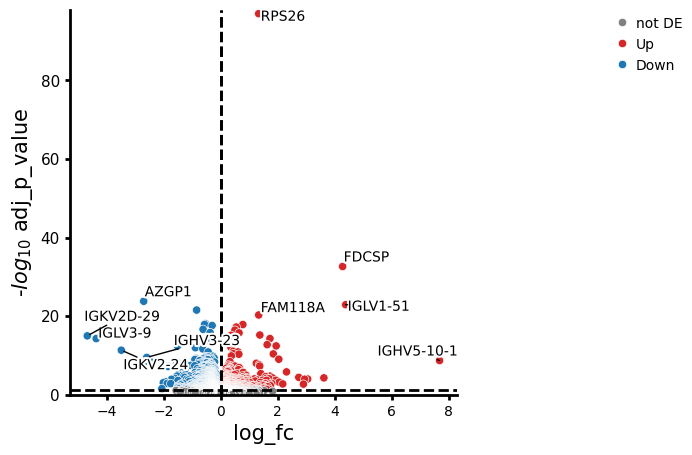

In [38]:
pds2.plot_volcano(res_df, log2fc_thresh=0)

We can also plot the fold changes of the top differentially expressed genes:

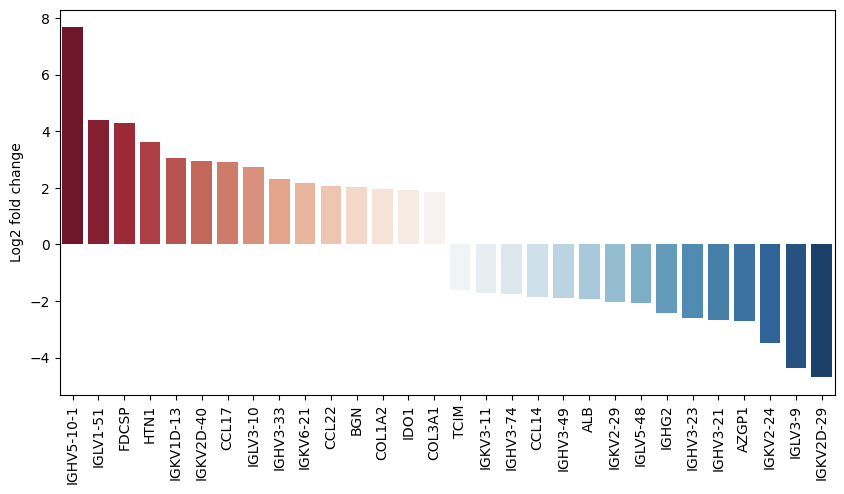

In [39]:
pds2.plot_fold_change(res_df, n_top_vars=15)

As already done for edgeR, we can also use PyDESeq2 to compare the gene expression levels between the different efficacy groups.

Fitting size factors...
... done in 0.20 seconds.

Fitting dispersions...
... done in 1.28 seconds.

Fitting dispersion trend curve...
... done in 0.43 seconds.

Fitting MAP dispersions...
... done in 1.37 seconds.

Fitting LFCs...
... done in 1.65 seconds.

Calculating cook's distance...
... done in 0.59 seconds.

Replacing 763 outlier genes.

Fitting dispersions...
... done in 0.19 seconds.

Fitting MAP dispersions...
... done in 0.20 seconds.

Fitting LFCs...
... done in 0.21 seconds.

Running Wald tests...
... done in 0.95 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  1. -1.]
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG      15.875276       -0.227366  0.091248 -2.491745  0.012712  0.123373
A1BG-AS1   1.866639       -0.120357  0.097829 -1.230283  0.218591  0.541743
A1CF       0.001864       -0.300999  2.865549 -0.105041  0.916344       NaN
A2M       28.369377        0.408009  0.325955  1.251733  0.210667  0.533217
A2M-AS1    0.519208       -0.336164  0.279740 -1.201704  0.229478  0.553523
...             ...             ...       ...       ...       ...       ...
ZXDC       5.649331        0.113855  0.083744  1.359560  0.173969  0.486861
ZYG11A     0.085097       -0.352026  0.555298 -0.633941  0.526119       NaN
ZYG11B     3.199099       -0.188299  0.111275 -1.692196  0.090609  0.352110
ZYX       73.825608       -0.124818  0.088878 -1.404363  0.160211  0.467537
ZZEF1      9.215947       -0.055120  0.085440 -0.645133  0.518841  0.784446

[24391 rows x 6 co

Running Wald tests...
... done in 0.99 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0.  0. -1.]
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
A1BG      15.875276        0.099344  0.206056  0.482124  6.297181e-01   
A1BG-AS1   1.866639       -0.326348  0.285776 -1.141970  2.534664e-01   
A1CF       0.001864        0.538179  6.245031  0.086177  9.313256e-01   
A2M       28.369377       -0.722471  0.718985 -1.004847  3.149704e-01   
A2M-AS1    0.519208       -0.336720  0.692627 -0.486149  6.268612e-01   
...             ...             ...       ...       ...           ...   
ZXDC       5.649331       -1.647885  0.286827 -5.745233  9.179459e-09   
ZYG11A     0.085097        0.076188  1.256279  0.060646  9.516414e-01   
ZYG11B     3.199099       -0.840877  0.314349 -2.674976  7.473466e-03   
ZYX       73.825608       -0.206289  0.197105 -1.046596  2.952859e-01   
ZZEF1      9.215947       -0.591402  0.219862 -2.689883  7.147712e-03   

                  padj  
A1BG      7.665237e-01  
A1BG

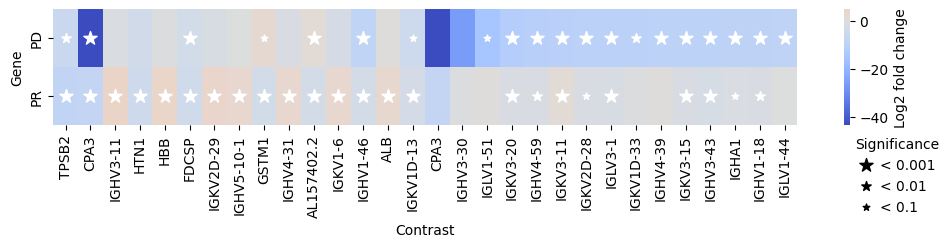

In [40]:
res_df = pds2.compare_groups(pdata, column="Efficacy", baseline="SD", groups_to_compare=["PR", "PD"])
edgr.plot_multicomparison_fc(res_df, figsize=(12, 1.5))

## Model interaction between covariates

We might be interested in more complex comparisons between patient groups. For example in this study instead of assuming that the type of treatment and its efficacy affect gene expression independently, we can test whether the gene expression changes associated to efficacy might depend on the type of treatment. To do this with a linear model, we model the interaction between the treatment and efficacy, following the syntax from [Wilkinson formulas](https://matthewwardrop.github.io/formulaic/latest/formulas/).

In [112]:
# Exclude patient with progressive disease, observed only for one treatment condition
pdata2 = pdata[pdata.obs["Efficacy"] != "PD"].copy()

# Fit DE model with interaction term
pds2 = pt.tl.PyDESeq2(adata=pdata2, design="~ Efficacy + Treatment + Efficacy*Treatment")
pds2.fit()

Fitting size factors...
... done in 0.19 seconds.

Fitting dispersions...
... done in 1.28 seconds.

Fitting dispersion trend curve...
... done in 0.36 seconds.

Fitting MAP dispersions...
... done in 1.30 seconds.

Fitting LFCs...
... done in 1.82 seconds.

Calculating cook's distance...
... done in 0.48 seconds.

Replacing 841 outlier genes.

Fitting dispersions...
... done in 0.22 seconds.

Fitting MAP dispersions...
... done in 0.23 seconds.

Fitting LFCs...
... done in 0.26 seconds.



We aim to identify genes that distinguish responders (`Efficacy="PR"`) from non-responders (`Efficacy="SD"`) specifically in patients treated with Anti-PD-L1, but not in those receiving standard chemotherapy. In other words, we want to find genes that are uniquely associated with treatment response in the Anti-PD-L1 group. To do so, we specify a contrast vector using the `cond()` helper function. This allows you to specify the conditions you want to compare without working out which combination of coefficients in the linear model correspond to your comparison of interest (see [here](https://formulaic-contrasts.readthedocs.io/en/latest/contrasts.html) to learn more about contrast vectors and how to build them). 

In [119]:
# Specify groups of interest for comparison
interaction_contrast = (
    pds2.cond(Treatment="Anti-PD-L1+Chemo", Efficacy="PR") - pds2.cond(Treatment="Anti-PD-L1+Chemo", Efficacy="SD")
) - (pds2.cond(Treatment="Chemo", Efficacy="PR") - pds2.cond(Treatment="Chemo", Efficacy="SD"))

In [120]:
interaction_contrast

Intercept                            0.0
Efficacy[T.SD]                       0.0
Treatment[T.Chemo]                   0.0
Efficacy[T.SD]:Treatment[T.Chemo]    1.0
Name: 0, dtype: float64

Now we are ready to test for differential expression

In [121]:
interaction_res_df = pds2.test_contrasts(interaction_contrast)

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [0. 0. 0. 1.]
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG      16.408605       -0.186209  0.184747 -1.007914  0.313496  0.563274
A1BG-AS1   1.958737       -0.221401  0.195560 -1.132141  0.257575  0.503996
A1CF       0.002053        0.472025  5.890327  0.080136  0.936129       NaN
A2M       30.296881       -0.912919  0.652515 -1.399076  0.161790  0.388201
A2M-AS1    0.557092       -0.631234  0.560717 -1.125762  0.260266  0.507278
...             ...             ...       ...       ...       ...       ...
ZXDC       6.114098        0.434843  0.169047  2.572315  0.010102  0.073847
ZYG11A     0.093600        0.708664  1.087454  0.651673  0.514612       NaN
ZYG11B     3.404941       -0.322007  0.228162 -1.411307  0.158154  0.383293
ZYX       77.175203       -0.278515  0.178490 -1.560394  0.118667  0.326861
ZZEF1      9.752162       -0.198511  0.175367 -1.131975  0.257645  0.504056

[24391 rows x 6 co

... done in 1.41 seconds.



NaNs encountered, dropping rows with NaNs


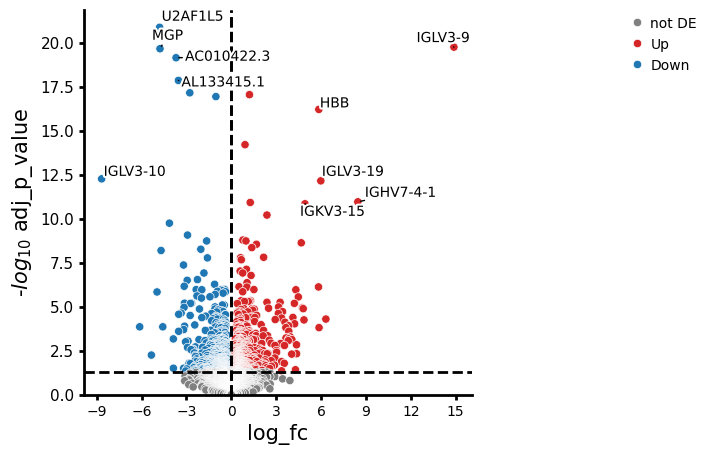

In [122]:
pds2.plot_volcano(interaction_res_df, log2fc_thresh=0)

We can also pass several contrasts to `test_contrasts`, for example to compare DE genes in responders specific to Anti-PD-L1 treatment to responses observed across treatments 

Running Wald tests...
... done in 1.09 seconds.



Log2 fold change & Wald test p-value, contrast vector: [0. 0. 0. 1.]
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG      16.408605       -0.186209  0.184747 -1.007914  0.313496  0.563274
A1BG-AS1   1.958737       -0.221401  0.195560 -1.132141  0.257575  0.503996
A1CF       0.002053        0.472025  5.890327  0.080136  0.936129       NaN
A2M       30.296881       -0.912919  0.652515 -1.399076  0.161790  0.388201
A2M-AS1    0.557092       -0.631234  0.560717 -1.125762  0.260266  0.507278
...             ...             ...       ...       ...       ...       ...
ZXDC       6.114098        0.434843  0.169047  2.572315  0.010102  0.073847
ZYG11A     0.093600        0.708664  1.087454  0.651673  0.514612       NaN
ZYG11B     3.404941       -0.322007  0.228162 -1.411307  0.158154  0.383293
ZYX       77.175203       -0.278515  0.178490 -1.560394  0.118667  0.326861
ZZEF1      9.752162       -0.198511  0.175367 -1.131975  0.257645  0.504056

[24391 rows x 6 co

Running Wald tests...
... done in 1.19 seconds.



Log2 fold change & Wald test p-value, contrast vector: [ 0. -1.  0.  0.]
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG      16.408605       -0.326639  0.130314 -2.506550  0.012192  0.077466
A1BG-AS1   1.958737       -0.273127  0.143175 -1.907649  0.056437  0.208860
A1CF       0.002053       -0.009129  4.074820 -0.002240  0.998212       NaN
A2M       30.296881       -0.194430  0.452892 -0.429308  0.667699  0.836704
A2M-AS1    0.557092       -0.661148  0.400237 -1.651894  0.098556  0.291391
...             ...             ...       ...       ...       ...       ...
ZXDC       6.114098        0.319336  0.122226  2.612657  0.008984  0.062783
ZYG11A     0.093600        0.009441  0.760581  0.012413  0.990096       NaN
ZYG11B     3.404941       -0.349948  0.162949 -2.147588  0.031746  0.144183
ZYX       77.175203       -0.314331  0.124708 -2.520538  0.011718  0.075496
ZZEF1      9.752162       -0.192871  0.125800 -1.533163  0.125236  0.334889

[24391 rows x 

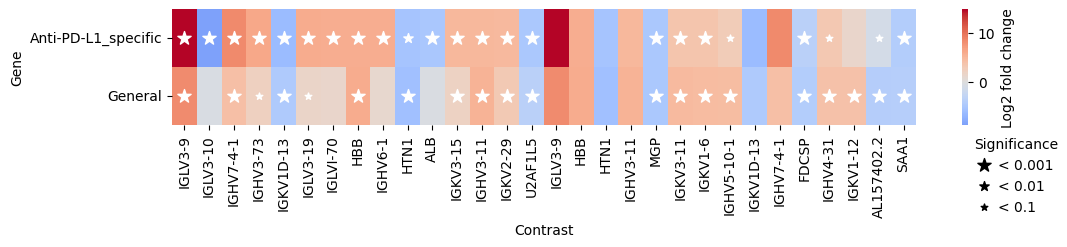

In [124]:
general_response_contrast = pds2.cond(Efficacy="PR") - pds2.cond(Efficacy="SD")

interaction_res_df = pds2.test_contrasts(
    {"Anti-PD-L1_specific": interaction_contrast, "General": general_response_contrast}
)

edgr.plot_multicomparison_fc(interaction_res_df, figsize=(12, 1.5))